## 导入包

In [55]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from copy import deepcopy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import RandomSampler
import matplotlib.pyplot as plt
import cv2

## 配置

In [56]:
# 需要修改成的数据大小
dsize = 128

## 文件路径

In [57]:
src = './competition_data'
save_weight_path = src + '/weight'
train_image_dir = src + '/train/images'
train_mask_dir = src + '/train/masks'
test_image_dir = src + '/test/images'

## 获取数据id

In [58]:
depths = pd.read_csv(src + '/train.csv')
all_ids = depths['id'].values # 取出所有id

## 我的模型(resnet 迁移学习)

In [92]:
class Decoder(nn.Module):
  def __init__(self,in_size,out_size,mid_size,scale) -> None:
    super().__init__()
    self.layer1 = nn.ConvTranspose2d(in_channels=in_size,out_channels=out_size,kernel_size=scale,stride=scale,padding=0)
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=mid_size,out_channels=out_size,stride=1,padding=1,kernel_size=3),
      nn.ReLU()
    )
  def forward(self,x1,x2):
    y1 = self.layer1(x1)
    tem = torch.cat((y1,x2),dim=1)
    y2 = self.layer2(tem)
    return y2

class resnet18_model(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    # 定义模型
    self.base_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    self.base_layers = list(self.base_model.children())
    self.input_test = torch.Tensor(12,1,128,128)
    self.layer_0 = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=1,stride=1)
    self.layer_1 = nn.Sequential(*self.base_layers[0:4])
    self.layer_2 = self.base_layers[4]
    self.layer_3 = self.base_layers[5]
    self.layer_4 = self.base_layers[6]
    self.layer_5 = self.base_layers[7]

    self.decoder1 = Decoder(512,256,256+128,4)
    self.decoder2 = Decoder(256,128,128+64,2)
    self.decoder3 = Decoder(128,64,64+3,4)

    self.layer_6 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,padding=2)
    self.layer_7 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)


    self.last = nn.Conv2d(in_channels=64,kernel_size=1,out_channels=1)

  def forward(self,input):
    # x1 = self.layer_0(input)# torch.Size([12, 3, 128, 128])

    x1 = self.layer_1(input) # torch.Size([12, 64, 32, 32])
    x2 = self.layer_2(x1) # torch.Size([12, 64, 32, 32])
    x3 = self.layer_3(x2) # torch.Size([12, 128, 16, 16])
    x4 = self.layer_4(x3) # torch.Size([12, 256, 8, 8])
    x5 = self.layer_5(x4) # torch.Size([12, 512, 4, 4])

    y1 = self.decoder1(x5,x3) # torch.Size([12, 256, 16, 16])
    y2 = self.decoder2(y1,x1) # torch.Size([12, 128, 32, 32])
    y3 = self.decoder3(y2,input) # torch.Size([12, 64, 128, 128])

    y4 = self.layer_6(y3)
    y5 = self.layer_7(y4) # torch.Size([12, 64, 128, 128])

    output = self.last(y5)

    return output

## 获取模型

In [93]:
def get_model(key):
  model = resnet18_model()
  model.load_state_dict(torch.load("./weight/" + key+ ".pth"))
  return model
salt = get_model("epoch_best")

## 主函数部分

In [61]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [62]:
def save_all():
  for id in all_ids:
    image = plt.imread(train_image_dir+'/'+id+'.png')[:,:,0:3] /255
    # mask = plt.imread(train_mask_dir+'/'+id+'.png') / 255
    image_tensor = torch.Tensor(
      cv2.resize(image,dsize=(128,128))
    ).reshape(1,3,128,128)
    output = salt(image_tensor)
    pre_image = output.squeeze().detach().numpy()
    plt.imsave(train_mask_dir+id+'_pre'+'.png',pre_image)

## 展示图片

In [63]:
def show_output(id):
  img = plt.imread(train_image_dir+'/'+id+'.png')
  image = img[:,:,0:3]
  # mask = cv2.resize(plt.imread(train_mask_dir+'/'+id+'.png'),dsize=(128,128))
  mask = plt.imread(train_mask_dir+'/'+id+'.png')
  image_tensor = torch.Tensor(
      cv2.resize(image,dsize=(128,128))
    ).reshape(1,3,128,128)
  output = salt(image_tensor)
  pre_image = torch.sigmoid(output.squeeze()).detach().numpy()
  
  plt.figure()
  plt.subplot(1,4,1)
  plt.imshow(pre_image)
  plt.subplot(1,4,2)
  plt.imshow(mask)
  plt.subplot(1,4,3)
  plt.imshow(img)
  plt.show()
  return pre_image,mask,img

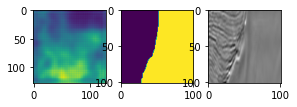

In [94]:
pre_image,mask,img = show_output(all_ids[30])

In [95]:
pre_image

array([[0.21662453, 0.1394847 , 0.13360076, ..., 0.08388186, 0.08800491,
        0.15001784],
       [0.15064763, 0.11313457, 0.10602259, ..., 0.06420826, 0.06432486,
        0.106079  ],
       [0.13585947, 0.1139863 , 0.11209288, ..., 0.06970595, 0.06648382,
        0.09976881],
       ...,
       [0.16253406, 0.14321136, 0.14619088, ..., 0.2099084 , 0.20255001,
        0.2302474 ],
       [0.19334874, 0.14884806, 0.1546571 , ..., 0.2079101 , 0.2089663 ,
        0.2551785 ],
       [0.25484756, 0.20915559, 0.19522348, ..., 0.2578873 , 0.28295523,
        0.34099537]], dtype=float32)

In [96]:
mask

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [97]:
img

array([[[0.34901962, 0.34901962, 0.34901962, 1.        ],
        [0.29411766, 0.29411766, 0.29411766, 1.        ],
        [0.28627452, 0.28627452, 0.28627452, 1.        ],
        ...,
        [0.4862745 , 0.4862745 , 0.4862745 , 1.        ],
        [0.4862745 , 0.4862745 , 0.4862745 , 1.        ],
        [0.4745098 , 0.4745098 , 0.4745098 , 1.        ]],

       [[0.49019608, 0.49019608, 0.49019608, 1.        ],
        [0.44313726, 0.44313726, 0.44313726, 1.        ],
        [0.4117647 , 0.4117647 , 0.4117647 , 1.        ],
        ...,
        [0.49019608, 0.49019608, 0.49019608, 1.        ],
        [0.4862745 , 0.4862745 , 0.4862745 , 1.        ],
        [0.4745098 , 0.4745098 , 0.4745098 , 1.        ]],

       [[0.6       , 0.6       , 0.6       , 1.        ],
        [0.5686275 , 0.5686275 , 0.5686275 , 1.        ],
        [0.5568628 , 0.5568628 , 0.5568628 , 1.        ],
        ...,
        [0.49411765, 0.49411765, 0.49411765, 1.        ],
        [0.4862745 , 0.486274

In [68]:
input_ = torch.Tensor(12, 64, 128, 128)
l1 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,padding=2)
l2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
outp = l1(input_)
outp = l2(outp)
outp.size()

torch.Size([12, 64, 128, 128])